<a href="https://colab.research.google.com/github/Sidy3143/Reinforcement-Learning/blob/main/PPO_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Goal:
     
     PPO's policy clipping mechanism limits
     the magnitude of policy updates, preventing
     the policy from changing drastically in a single step.
     This safeguards against performance collapse but
     can slow down learning as the policy is refined incrementally.


    No ReplayBuffer just a memory that stores esperiences at each 20
    steps and use it to train its model and immediately clear it to store new experiences.

  This makes **PPO an on policy method because only current actions taken are actually used to train the network**

The Calculation of the Gradients of the Actor skips the  Categorical distribution since they are non differentiable. Instead we differentiate the Log Probabilities of the choosen action which depends on the network parameters.

This though introduces some **stochasticity**.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                np.array(self.dones),\
                batches

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []

In [ ]:
class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha,
            fc1_dims=256, fc2_dims=256, chkpt_dir='tmp/ppo'):
        super(ActorNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_lunarlander_ppo')
        self.actor = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, n_actions),
                nn.Softmax(dim=-1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)

        return dist

    def save_checkpoint(self):
        os.makedirs(os.path.dirname(self.checkpoint_file), exist_ok=True)  # Create directory if it doesn't exist
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims=256, fc2_dims=256,
            chkpt_dir='tmp/ppo'):
        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_lunarlander_ppo')
        self.critic = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, 1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        value = self.critic(state)

        return value

    def save_checkpoint(self):
        os.makedirs(os.path.dirname(self.checkpoint_file), exist_ok=True)
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))


In [ ]:
class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
            policy_clip=0.2, batch_size=64, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda

        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)

    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print('... loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor.device) #2D tensor

        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        probs = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()

        return action, probs, value

    def learn(self):

        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr, reward_arr, dones_arr, batches = self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32) #not 64

            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]* (1-int(dones_arr[k])) - values[k])    #At= δt + λ*γ * δ(t+1) +... with δt = rt + γ* V(t+1) - Vt
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = T.tensor(advantage).to(self.actor.device)
            values = T.tensor(values).to(self.actor.device)

            for batch in batches:
                states = T.tensor(state_arr[batch], dtype=T.float).to(self.actor.device)
                old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = T.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)

                critic_value = T.squeeze(critic_value)

                new_probs = dist.log_prob(actions)               # log probabilities under the current policy
                prob_ratio = new_probs.exp() / old_probs.exp()   #prob_ratio = (new_probs - old_probs).exp()

                weighted_probs = advantage[batch] * prob_ratio # advantageous and more probable under the updated policy.
                weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip, 1+self.policy_clip)*advantage[batch]  #like clip

                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.clear_memory() # crucial

In [ ]:
def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    os.makedirs(os.path.dirname(figure_file), exist_ok=True)
    plt.savefig(figure_file)

In [ ]:
!apt-get install swig
!pip install gym[box2d]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 2s (599 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 123632 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubunt

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


... saving models ...
episode 0 score -104.6 avg score -104.6 time_steps 69 learning_steps 3
episode 1 score -434.3 avg score -269.4 time_steps 180 learning_steps 9
episode 2 score -368.1 avg score -302.3 time_steps 267 learning_steps 13
episode 3 score -115.3 avg score -255.6 time_steps 332 learning_steps 16
episode 4 score -214.5 avg score -247.4 time_steps 437 learning_steps 21
episode 5 score -583.9 avg score -303.5 time_steps 527 learning_steps 26
episode 6 score -508.5 avg score -332.8 time_steps 594 learning_steps 29
episode 7 score -108.6 avg score -304.7 time_steps 726 learning_steps 36
episode 8 score -87.8 avg score -280.6 time_steps 802 learning_steps 40
episode 9 score -173.0 avg score -269.9 time_steps 915 learning_steps 45
episode 10 score -79.5 avg score -252.6 time_steps 976 learning_steps 48
episode 11 score -416.8 avg score -266.2 time_steps 1065 learning_steps 53
episode 12 score -137.8 avg score -256.4 time_steps 1124 learning_steps 56
episode 13 score -111.4 avg s

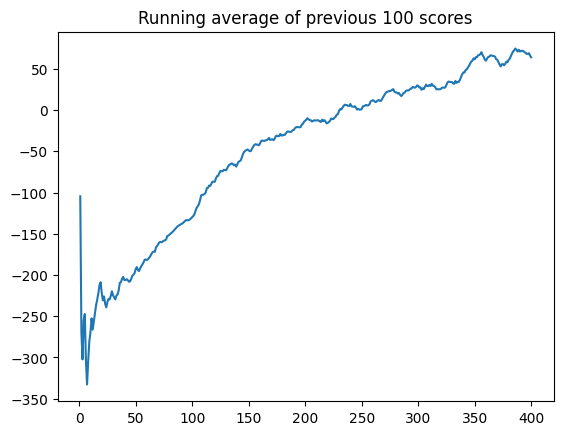

In [ ]:
import gym


env = gym.make('LunarLander-v2')
N = 20
batch_size = 5
n_epochs = 4
alpha = 0.0003
agent = Agent(n_actions=env.action_space.n, batch_size=batch_size,
                alpha=alpha, n_epochs=n_epochs,
                input_dims=env.observation_space.shape)
n_games = 400

figure_file = 'plots/lunarlander.png'

best_score = env.reward_range[0]
score_history = []

learn_iters = 0
avg_score = 0
n_steps = 0

for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0
    while not done:
        action, prob, val = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        n_steps += 1
        score += reward
        agent.remember(observation, action, prob, val, reward, done)
        if n_steps % N == 0:
            agent.learn()
            learn_iters+= 1
        observation = observation_
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()

    print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score,'time_steps', n_steps, 'learning_steps', learn_iters)

x = [i+1 for i in range(len(score_history))]
plot_learning_curve(x, score_history, figure_file)



In [ ]:
import os
# path_name = "PPO_lunar_lander"
# os.makedirs(path_name, exist_ok=True)
agent.save_models()

... saving models ...


In [ ]:
!pip install pyvirtualdisplay
!apt-get update
!apt-get install -y xvfb # Install xvfb

from pyvirtualdisplay import Display

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,626 kB]
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3,331 kB]
Get:13 https://ppa.launchpadcontent.net/deadsnak

In [ ]:
import numpy as np
from gym.wrappers import record_video
from IPython.display import HTML
from base64 import b64encode

# Create directory for videos if it doesn't exist
video_dir = "./videos"
if not os.path.exists(video_dir):
    os.makedirs(video_dir)

env = record_video.RecordVideo(env, video_dir, episode_trigger=lambda episode_id: True)

# Function to show video in Colab
def show_video(video_path):
    mp4 = open(video_path, 'rb').read()
    base64_encoded = b64encode(mp4).decode()
    return HTML(f'<video width=600 controls><source src="data:video/mp4;base64,{base64_encoded}" type="video/mp4"></video>')

# Run episodes and record
scores = []
episodes = 4
for episode in range(episodes):
    obs = env.reset()
    done = False
    t = 0
    score = 0

    while not done and t <= 100:
        action, prob, val = agent.choose_action(obs)
        obs, reward, done, info = env.step(action)
        score += reward
        if done:
            print(f"Episode {episode} finished after {t+1} timesteps.")
        t += 1

    scores.append(score)
    if (episode + 1) % 100 == 0:
        print(f"Episode {episode} avg_score {np.mean(scores[-100:])}")

env.close()

# Display the most recent video
video_files = [os.path.join(video_dir, f) for f in os.listdir(video_dir) if f.endswith('.mp4')]
if video_files:
    latest_video = max(video_files, key=os.path.getctime)
    display(show_video(latest_video))

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initializat